In [1]:
import numpy as np
import fitsio
import matplotlib.pyplot as plt
import h5py
from scipy import interpolate
import os
import tqdm
import scipy.optimize
import healpy as hp
# sys.path.append('/home/zhuoqizhang/miniconda3/envs/shearDM/lib/python3.10/site-packages/')
import pymaster as nmt
import os
nside = 1024
npix = hp.nside2npix(nside)

In [2]:
def get_cat(fname): 
    
    data_array = np.load(f'/project2/chihway/dhayaa/DES_Catalogs/{fname}')
    e1 = data_array['e1']
    e2 = -data_array['e2']
    ra = data_array['ra']
    dec = data_array['dec']
    weight = data_array['w']
    
    return e1, e2, ra, dec, weight

In [3]:
def make_map(e1, e2, ra, dec, weight, nside=1024):
    
    pix = hp.nside2npix(nside)
    map_counts = np.zeros(npix)
    map_e1 = np.zeros(npix)
    map_e2 = np.zeros(npix)
    pix = hp.ang2pix(nside, ra, dec, lonlat=True)
    ind, counts = np.unique(pix, return_counts=True)
    map_weight = np.bincount(pix, weight, minlength=npix)
    # Note that we set response to 1. This shouldn't change the relative amplitude of C_ell
    map_e1 += np.bincount(pix,e1*weight,minlength=npix)/map_weight
    map_e2 += np.bincount(pix,e2*weight,minlength=npix)/map_weight
    map_e1[np.isnan(map_e1)] = 0
    map_e2[np.isnan(map_e2)] = 0
    mask = map_weight
    
    return map_counts, map_e1, map_e2, map_weight, mask

In [4]:
def nmt_measure(map_e1, map_e2, mask): 
    
    edge = (np.linspace(np.sqrt(8), np.sqrt(2048), 33)**2).astype(np.int_)
    b = nmt.NmtBin.from_edges(edge[:-1],edge[1:])
    ell_eff = b.get_effective_ells()
    f2 = nmt.NmtField(mask, [map_e1, map_e2])
    w = nmt.NmtWorkspace()
    w.compute_coupling_matrix(f2, f2, b)
    cl_coupled = nmt.compute_coupled_cell(f2, f2)
    cl_decoupled = w.decouple_cell(cl_coupled)
    
    return w, cl_decoupled

In [5]:
def rotate_ellipticities(e1, e2, rot_angle):
        """
        Random rotate ellipticities e1 and e2 over
        angles given in `rot_angle`, which is in
        units of radians
        """

        #Rotate galaxy shapes randomly
        cos = np.cos(rot_angle)
        sin = np.sin(rot_angle)

        e1_rand = + e1 * cos + e2 * sin
        e2_rand = - e1 * sin + e2 * cos

        return e1_rand, e2_rand

In [6]:
def random_sample(mask, ra, dec, e1, e2, workspace, N=10, nside=1024): 
    
    npix = hp.nside2npix(nside)
    footprint = mask!=0
    BB_rand = []
    
    for j in tqdm.trange(0,N): 

        # generate random_samples
        pix = hp.ang2pix(nside, ra, dec, lonlat=True)
        rot_angle = np.random.default_rng(j).random(e1.size)*2*np.pi
        e1_rot, e2_rot = rotate_ellipticities(e1, e2, rot_angle)

        rand_e1 = np.zeros(npix)
        rand_e2 = np.zeros(npix)
        rand_e1[footprint] = np.bincount(pix,e1_rot*weight,minlength=npix)[footprint]/map_weight[footprint]
        rand_e2[footprint] = np.bincount(pix,e2_rot*weight,minlength=npix)[footprint]/map_weight[footprint]
        frand = nmt.NmtField(mask, [rand_e1, rand_e2])
        BB_rand.append(workspace.decouple_cell(nmt.compute_coupled_cell(frand, frand)))
        
    BB_rand = np.array(BB_rand)
    return BB_rand

In [2]:
dir_list = os.listdir('/project2/chihway/dhayaa/DES_Catalogs/')
fnames = []
for fname in dir_list: 
    if fname.startswith('DELVE'):
        fnames.append(fname)
fnames = np.sort(fnames)

In [3]:
fnames[4][27:-4]

'SNRLow30'

SNRHigh200


/tmp/ipykernel_47897/3913699195.py:23: RuntimeWarning: invalid value encountered in divide
  map_e1 += np.bincount(pix,e1*weight,minlength=npix)/map_weight
/tmp/ipykernel_47897/3913699195.py:24: RuntimeWarning: invalid value encountered in divide
  map_e2 += np.bincount(pix,e2*weight,minlength=npix)/map_weight
100%|███████████████████████████████████████████████████████████████████████████████████| 10/10 [03:37<00:00, 21.77s/it]


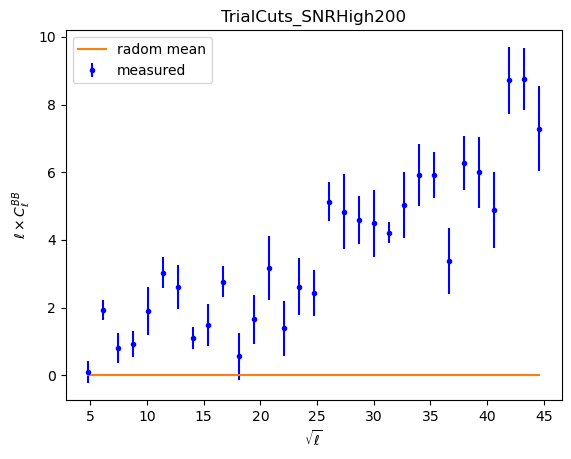

SNRHigh500


100%|███████████████████████████████████████████████████████████████████████████████████| 10/10 [03:34<00:00, 21.47s/it]


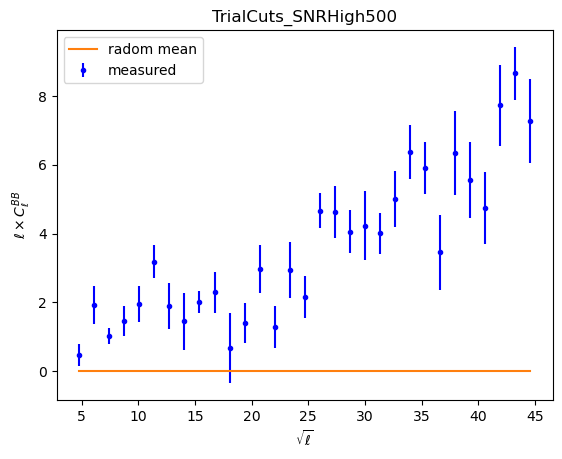

SNRLow20


100%|███████████████████████████████████████████████████████████████████████████████████| 10/10 [02:46<00:00, 16.66s/it]


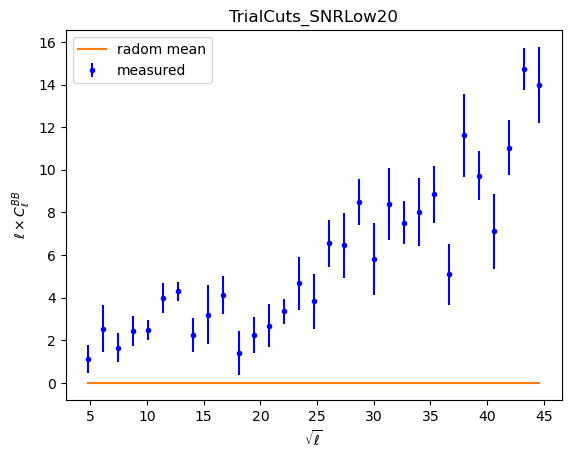

SNRLow30


100%|███████████████████████████████████████████████████████████████████████████████████| 10/10 [02:29<00:00, 14.94s/it]


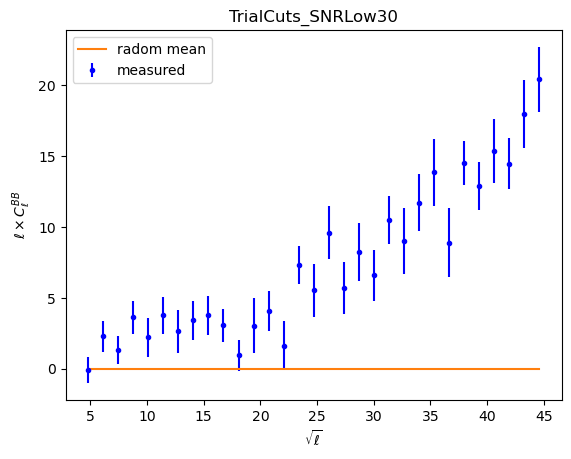

SNRLow40


100%|███████████████████████████████████████████████████████████████████████████████████| 10/10 [02:03<00:00, 12.38s/it]


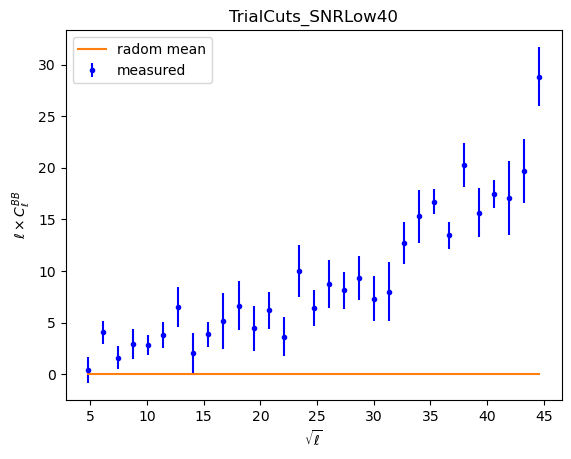

THigh1


100%|███████████████████████████████████████████████████████████████████████████████████| 10/10 [03:11<00:00, 19.18s/it]


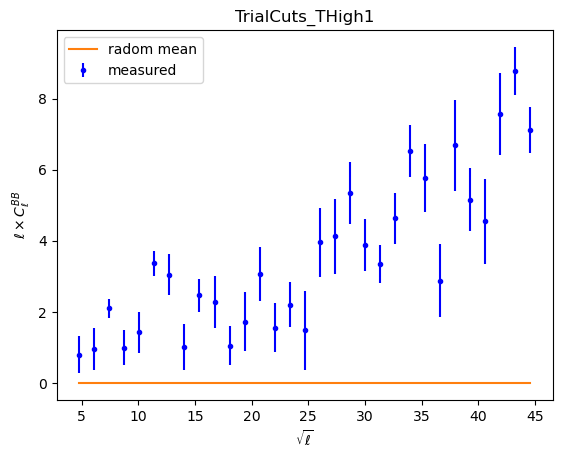

THigh2


100%|███████████████████████████████████████████████████████████████████████████████████| 10/10 [03:31<00:00, 21.20s/it]


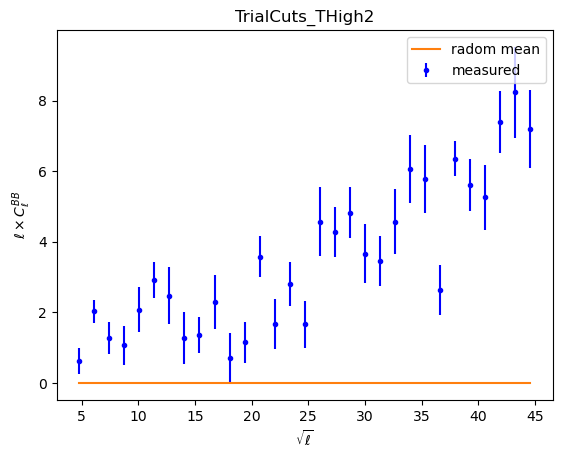

THigh5


100%|███████████████████████████████████████████████████████████████████████████████████| 10/10 [03:39<00:00, 21.91s/it]


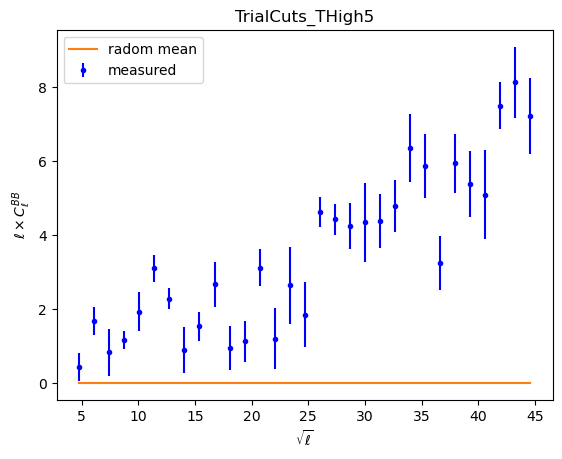

TratioLow1


100%|███████████████████████████████████████████████████████████████████████████████████| 10/10 [02:28<00:00, 14.86s/it]


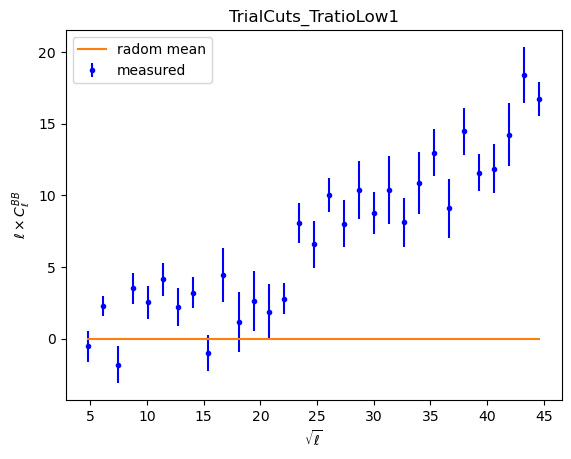

TratioLow2


100%|███████████████████████████████████████████████████████████████████████████████████| 10/10 [01:46<00:00, 10.64s/it]


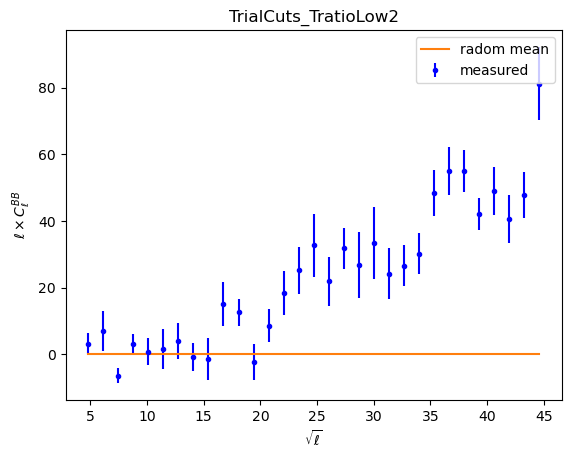

TratioLow3


100%|███████████████████████████████████████████████████████████████████████████████████| 10/10 [01:27<00:00,  8.79s/it]


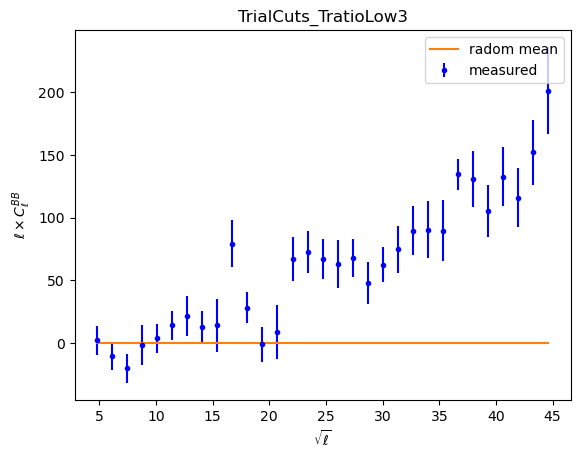

In [32]:
N=10

for fname in fnames[1:]:
    #fname = fnames[0]
    print(fname[27:-4])

    data_array = np.load(f'/project2/chihway/dhayaa/DES_Catalogs/{fname}')
    e1 = data_array['e1']
    e2 = -data_array['e2']
    ra = data_array['ra']
    dec = data_array['dec']
    weight = np.ones_like(e1)


    pix = hp.nside2npix(nside)
    map_counts = np.zeros(npix)
    map_e1 = np.zeros(npix)
    map_e2 = np.zeros(npix)
    pix = hp.ang2pix(nside, ra, dec, lonlat=True)
    ind, counts = np.unique(pix, return_counts=True)
    map_weight = np.bincount(pix, weight, minlength=npix)
    # Note that we set response to 1. This shouldn't change the relative amplitude of C_ell
    map_e1 += np.bincount(pix,e1*weight,minlength=npix)/map_weight
    map_e2 += np.bincount(pix,e2*weight,minlength=npix)/map_weight
    map_e1[np.isnan(map_e1)] = 0
    map_e2[np.isnan(map_e2)] = 0
    mask = map_weight


    edge = (np.linspace(np.sqrt(8), np.sqrt(2048), 33)**2).astype(np.int_)
    b = nmt.NmtBin.from_edges(edge[:-1],edge[1:])
    ell_eff = b.get_effective_ells()
    f2 = nmt.NmtField(mask, [map_e1, map_e2])
    w = nmt.NmtWorkspace()
    w.compute_coupling_matrix(f2, f2, b)
    cl_coupled = nmt.compute_coupled_cell(f2, f2)
    cl_decoupled = w.decouple_cell(cl_coupled)


    np.save(f'/project2/chihway/jackie/decade/Bmode/trial_cuts/Cl_{fname[27:-4]}', cl_decoupled)


    footprint = mask!=0
    BB_rand = []

    for j in tqdm.trange(N): 

        # generate random_samples
        pix = hp.ang2pix(nside, ra, dec, lonlat=True)
        rot_angle = np.random.default_rng(j).random(e1.size)*2*np.pi
        e1_rot, e2_rot = rotate_ellipticities(e1, e2, rot_angle)

        rand_e1 = np.zeros(npix)
        rand_e2 = np.zeros(npix)
        rand_e1[footprint] = np.bincount(pix,e1_rot*weight,minlength=npix)[footprint]/map_weight[footprint]
        rand_e2[footprint] = np.bincount(pix,e2_rot*weight,minlength=npix)[footprint]/map_weight[footprint]
        frand = nmt.NmtField(mask, [rand_e1, rand_e2])
        BB_rand.append(w.decouple_cell(nmt.compute_coupled_cell(frand, frand)))

    BB_rand = np.array(BB_rand)   
    np.save(f'/project2/chihway/jackie/decade/Bmode/trial_cuts/rand_{fname[27:-4]}', BB_rand)


    mean = np.mean(BB_rand[:,3,1:],axis=0)
    std = np.std(BB_rand[:,3,1:],axis=0)
    plt.errorbar(np.sqrt(ell_eff[1:]), 1e8*ell_eff[1:]*(cl_decoupled[3][1:]-mean), yerr=1e8*ell_eff[1:]*std,label='measured',fmt='.b')
    plt.plot(np.sqrt(ell_eff[1:]), 0*mean, color='tab:orange',label='radom mean')
    plt.legend()
    plt.xlabel(r'$\sqrt{\ell}$')
    plt.ylabel(r'$\ell\times C_\ell^{BB}$')
    plt.title(fname[17:-4])
    plt.show()

### Plot

In [13]:
edge = (np.linspace(np.sqrt(8), np.sqrt(2048), 33)**2).astype(np.int_)
b = nmt.NmtBin.from_edges(edge[:-1],edge[1:])
ell_eff = b.get_effective_ells()[1:]

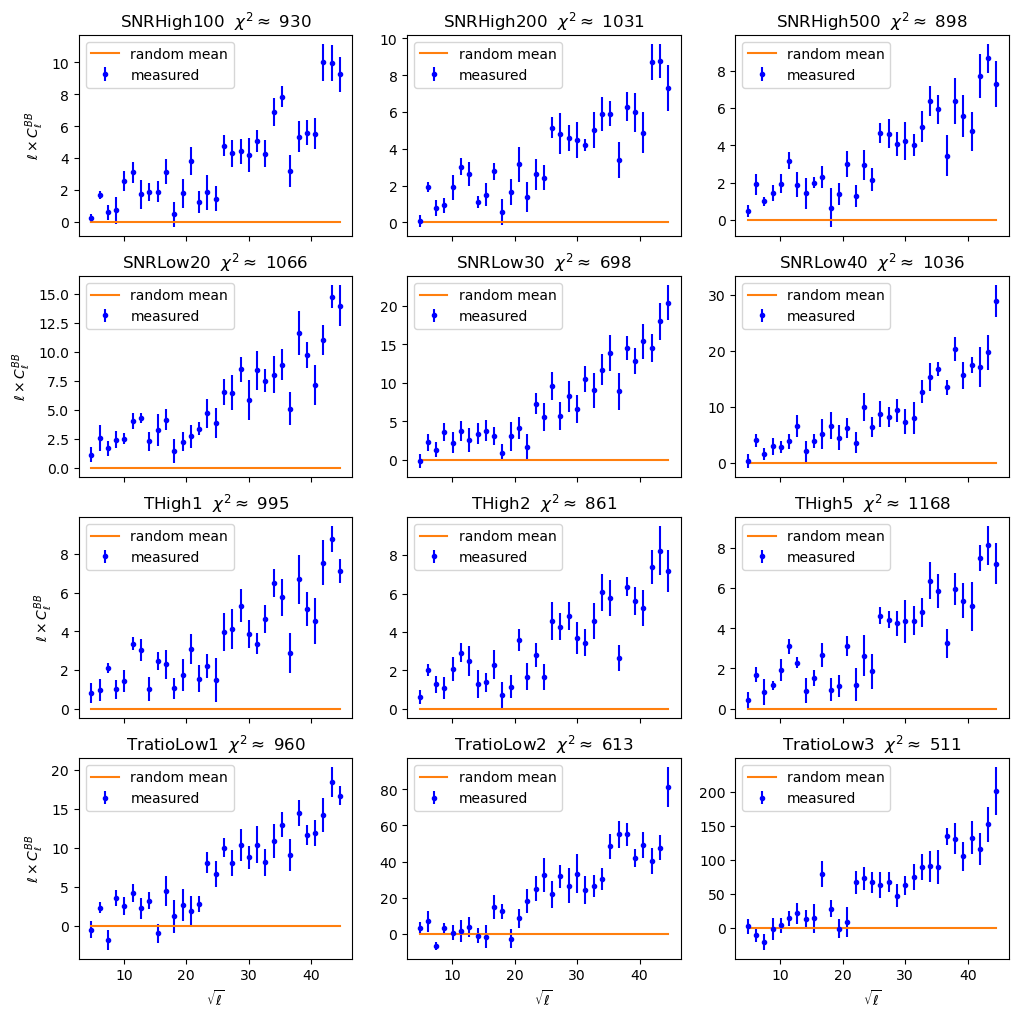

In [22]:
fig, axs = plt.subplots(4, 3, figsize=(12,12), sharex=True)
for i in range(0,12):
    row = i//3
    col = i%3
    fname = fnames[i]
    
    Cl_BB = np.load(f'/project2/chihway/jackie/decade/Bmode/trial_cuts/Cl_{fname[27:-4]}.npy')[3,1:]
    Cl_rand = np.load(f'/project2/chihway/jackie/decade/Bmode/trial_cuts/rand_{fname[27:-4]}.npy')[:,3,1:]
    mean = np.mean(Cl_rand,axis=0)
    std = np.std(Cl_rand,axis=0)
    chi2 = np.sum((Cl_BB-mean)**2/std**2)
    
    axs[row][col].errorbar(np.sqrt(ell_eff), 1e8*ell_eff*(Cl_BB-mean), yerr=1e8*ell_eff*std,label='measured',fmt='.b')
    axs[row][col].plot(np.sqrt(ell_eff), 0*mean, color='tab:orange',label='random mean')
    axs[row][col].legend()
    if row == 3: 
        axs[row][col].set_xlabel(r'$\sqrt{\ell}$')
    if col == 0: 
        axs[row][col].set_ylabel(r'$\ell\times C_\ell^{BB}$')
    axs[row][col].set_title(f'{fname[27:-4]}  '+r'$\chi^2\approx$'+f' {int(chi2)}')